In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as mt
from scipy.interpolate import BSpline, make_interp_spline
from scipy.optimize import curve_fit

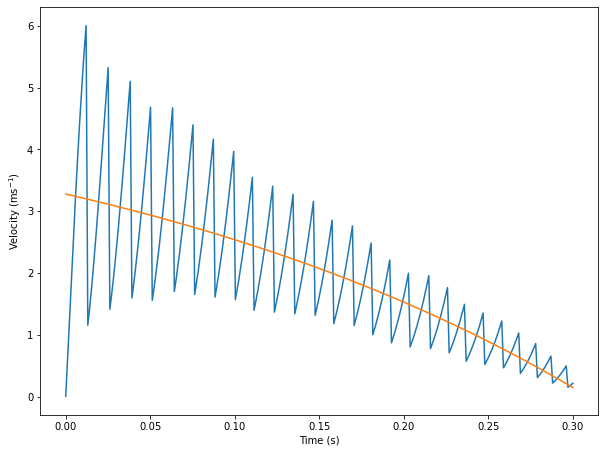

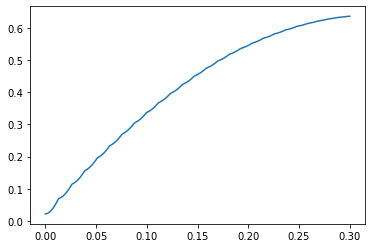

In [20]:

# small metal parameters
# M = 0.1779 # Mass of slinky
# L = 1.09 # Length of unstrechted slinky         
# g = 9.81 # g value          
# k = 0.77 # Spring costant
# tau = 0.40

# M = 0.375 # Mass of slinky
# L = 3.61 # Length of unstrechted slinky         
# g = 9.81 # g value          
# k = 0.39 # Spring costant
# tau = 0.60

M = 0.043 # Mass of slinky
L = 0.71 # Length of unstrechted slinky         
g = 9.81 # g value          
k = 0.31 # Spring costant
tau = 0.30 # Estimated falling tim

# Parameters for finite difference method
v_lambda = (M*g)/k
omega = np.sqrt(k/M)
interval = 30 # number of discrete values to compute over               
dx = 1 / interval # discrete value dx
dt = 0.001  # discrete value of dt
h = (omega * dt / dx)**2 # h needs to be between 0<h<1 

# Coordinate of slinky between 0 and 1 
x = np.linspace(0, 1, interval + 1)

# Initial conditions defined at t=0
# y = 1/2 * lambda x^2 since dy / dt = 0 
y_prime_old = 0.5 * v_lambda * x**2  # At t = 0 
y_prime_now = y_prime_old.copy()

# New values are initially zero
y_prime_new = np.zeros_like(y_prime_now)

final_y_value = np.zeros_like(y_prime_now)
final_y_value_old = y_prime_now.copy()

t = 0.0
# Defining time range with interval of dt
times = np.linspace(0, tau, int(tau / dt))
data_wave_eq = []

# Computing for each time the y coordinate 
for t in times: 
    # Computing the y coordinate using the finite difference method
    for i in range(1, interval):
        y_prime_new[i] = 2 * y_prime_now[i] - y_prime_old[i] + \
        h * (y_prime_now[i+1] + y_prime_now[i-1] - 2 * y_prime_now[i])
    
    # Applying boundary conditions at x = 0, 
    #dy/dx = 0 , so y = constant 
    y_prime_new[0] = y_prime_new[1] # dy/dx = 0  
    
    # Applying boundary conditions at x = 1
    # so dy/dx = -lambda , y = constant - lambda *x
    y_prime_new[-1] = y_prime_new[-2] - v_lambda * dx  
    
    # Defining the old y coordinate from the new y coordinate
    for i in range(0,len(x)):
        y_prime_old[i]=y_prime_now[i]
        y_prime_now[i] = y_prime_new[i].copy()
        
    # Including gravitational fall from the current y coordinate
    final_y_value = -0.5 * g * t**2 + y_prime_now
    velocity = (final_y_value - final_y_value_old) / dt
    
    # Append data 
    for i in range(len(x)):
        data_wave_eq.append({'time': t,'position': final_y_value[i],'x': x[i],'velocity': velocity[i]})  
    # The old y value is the new y value
    final_y_value_old = final_y_value.copy()
    
# Converting the data to dataframe
# Start time on 0 to end of falling. 
df = pd.DataFrame(data_wave_eq)
idx = df.groupby('time')['position'].idxmax()
df_max = df.loc[idx].reset_index(drop=True)
df_max['velocity'] = df_max['velocity'].abs()
df_max['position'] = df_max['position'].max() + df_max['position'].min() - df_max['position']

velocity = df_max['velocity']
time = df_max['time']
position = df_max['position']

# Compute fitting through modeled data
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
param_t, pcov_1 = curve_fit(func, time, velocity, p0=[0,0,3],maxfev=2000)
param_p, pcov_2 = curve_fit(func, position, velocity, p0=[0,0,3],maxfev=2000)

# Computing velocity with r.s to position and time
velocity_func_time = func(time, *param_t)
velocity_func_position = func(position, *param_p)
df_max['v_m_t'] = velocity_func_time
df_max['v_m_p'] = velocity_func_position

plt.figure(figsize=(10,7.5))
plt.plot(df_max['time'], df_max['velocity'])
#plt.plot(df_max['time'], df_max['position'])
plt.plot(df_max['time'], df_max['v_m_t'])
plt.xlabel('Time (s)')
plt.ylabel(r'Velocity (ms$^{-1}$)')

plt.show()
#df_max.to_csv("Converted_data_plastic_slinky.csv")

plt.plot(df_max['time'], df_max['position'])

plt.show()

In [21]:
# Convert the modeled data to CSV file
# Has to be done for each slinky 
#df_max.to_csv("Converted_data_plastic_slinky.csv")

df.rename(columns={'x': 'zeta'}, inplace=True)
df.to_csv('Data_plastic_slinky.csv')

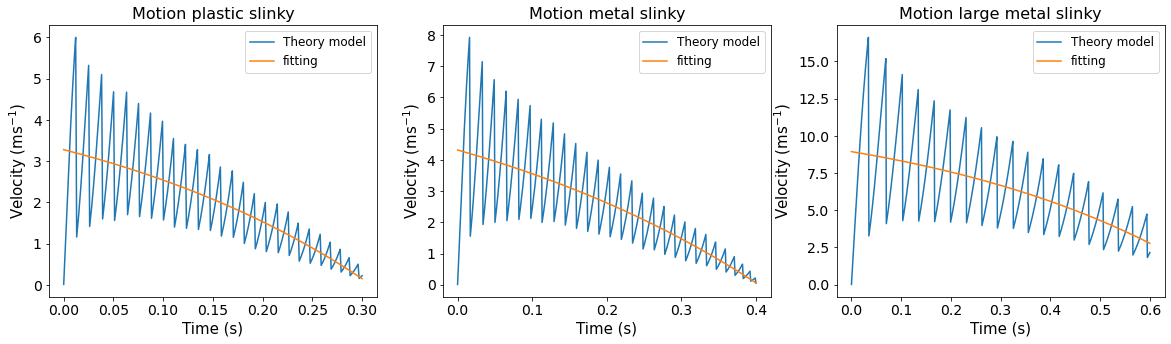

In [22]:
# Loading the modeled data of the slinkys
df_modeled_metal = pd.read_csv("Converted_data_metal_slinky.csv")
df_modeled_plastic = pd.read_csv("Converted_data_plastic_slinky.csv")
df_modeled_metal_big = pd.read_csv("Converted_data_metal_big_slinky.csv")

fig, axs = plt.subplots(1,3, figsize=(20,5))

# Plotting the theoretical model (velocities) of the three slinkys
axs[0].plot(df_modeled_plastic['time'], df_modeled_plastic['velocity'], label='Theory model')
axs[1].plot(df_modeled_metal['time'], df_modeled_metal['velocity'], label='Theory model')
axs[2].plot(df_modeled_metal_big['time'], df_modeled_metal_big['velocity'], label='Theory model')

axs[0].plot(df_modeled_plastic['time'], df_modeled_plastic['v_m_t'], label='fitting')
axs[1].plot(df_modeled_metal['time'], df_modeled_metal['v_m_t'], label='fitting')
axs[2].plot(df_modeled_metal_big['time'], df_modeled_metal_big['v_m_t'],label='fitting')

# Set characteristics of the plot
title = ['Motion plastic slinky','Motion metal slinky', 'Motion large metal slinky']
for i in np.arange(0, 3):
        axs[i].set_title(title[i], fontsize=16)
        axs[i].set_xlabel('Time (s)', fontsize=15)
        axs[i].set_ylabel(r'Velocity (ms$^{-1}$)', fontsize=15)
        axs[i].legend(loc= 'upper right', fontsize=12)
        axs[i].tick_params(axis='both', labelsize=14)
plt.savefig("Plotted_model.pdf")

Velocity_diff    1.324289
error_v          0.632155
dtype: float64
Velocity_diff    1.313453
error_v          0.768142
dtype: float64
Velocity_diff    3.357542
error_v          1.791069
dtype: float64


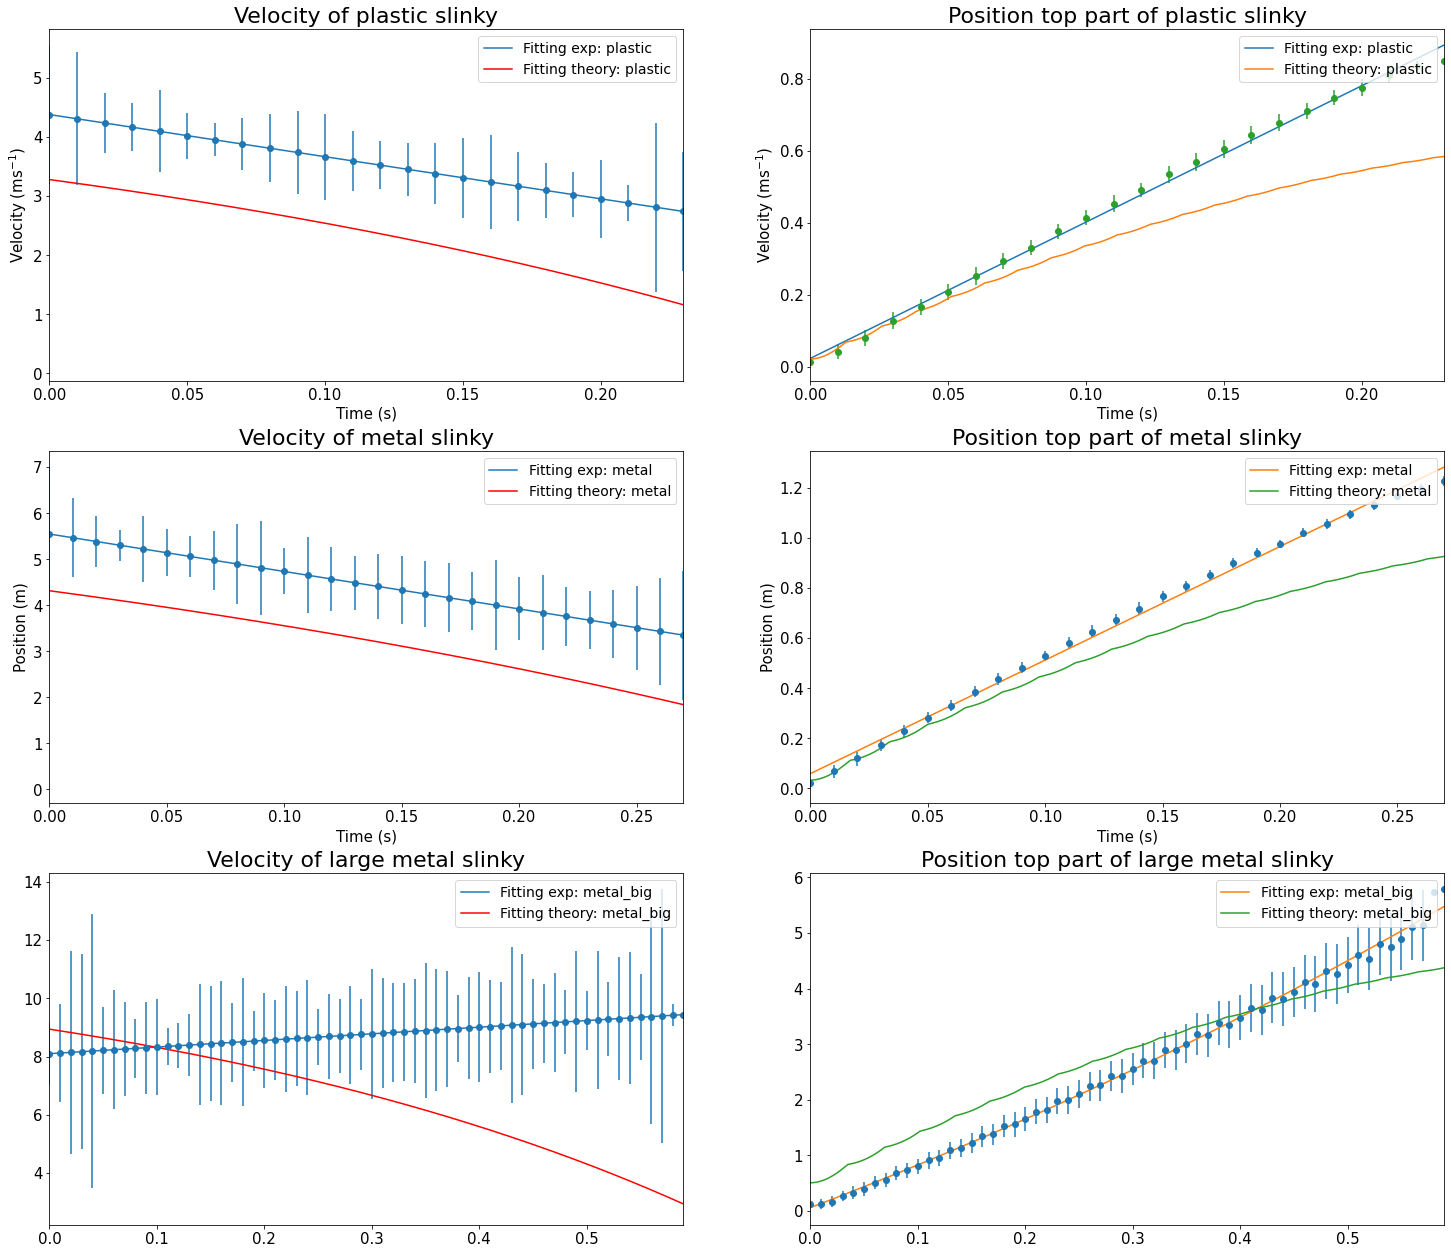

In [23]:
# Fitting curve to the data points
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Load the files 
df = pd.read_csv("data_raw_slinkies_experiment_new_measurements.csv", delimiter=';')
df_modeled_metal = pd.read_csv("Converted_data_metal_slinky.csv")
df_modeled_plastic = pd.read_csv("Converted_data_plastic_slinky.csv")
df_modeled_metal_big = pd.read_csv("Converted_data_metal_big_slinky.csv")
df_modeled_metal['sort'] = 'metal'
df_modeled_plastic['sort'] = 'plastic'
df_modeled_metal_big['sort'] = 'metal_big'
df_modeled = pd.concat([df_modeled_metal, df_modeled_plastic, df_modeled_metal_big])

#df_olympias = pd.read_csv("Modeled_data_olympicas.csv")
trials = np.arange(1,7)
sorts = ['plastic', 'metal', 'metal_big']
df_n = pd.DataFrame()

df['y'] = df['y'].abs()
df['v'] = df['v'].abs()
df['t'] = df['t'].round(2)

# changing the times to 0 to falling 
for sort in sorts:
    for trial in trials:
        df_f = df[(df['Trial'] == trial) & (df['Sort'] == sort)].copy()
        if trial == 6 and sort == 'metal_big':
            break
        df_f['time']= df_f['t'] - min(df_f['t'])
        df_n = pd.concat([df_n, df_f])
pd.set_option('display.max_rows', None)
df_n['time'] = df_n['time'].round(2)

# Group the data by time and sort and mean the velocity
df_n["time"] = pd.to_numeric(df_n["time"])

groupby_time_error = df_n.groupby(['Sort', 'time'])['v'].std().reset_index()
groupby_position_error = df_n.groupby(['Sort', 'time'])['y'].std().reset_index()

groupby_time_error.rename(columns={'v': 'error_v'}, inplace=True)
groupby_position_error.rename(columns={'y': 'error_y'}, inplace=True)

groupby_time = df_n.groupby(['Sort', 'time'])['v'].mean().reset_index()
groupby_position = df_n.groupby(['Sort', 'time'])['y'].mean().reset_index()
#print(groupby_position)
#df.to_csv('converted_data_for_experiment_slinky.csv')


# plotting experimental data:
fig, axs = plt.subplots(3,2, figsize=(25,22))
extra_data_frame = pd.DataFrame()
for sort in sorts:
    # Define the filters for the three datasets
    df_f_t = groupby_time[(groupby_time['Sort'] == sort)].copy()
    df_f_p = groupby_position[(groupby_position['Sort'] == sort)].copy()
    
    # Define error bars
    df_f_p_error = groupby_position_error[(groupby_position_error['Sort'] == sort)].copy()
    df_t_t_error = groupby_time_error[(groupby_time_error['Sort'] == sort)].copy()
    
    df_modeled_filter = df_modeled[(df_modeled['sort'] == sort)]
    #df_olympias_filter = df_olympias[(df_olympias['sort'] == sort)]
    # Define variables on time
    t_exp = df_f_t['time']
    v_exp = df_f_t['v']
    v_exp_error = df_t_t_error['error_v']
    popt, pcov = curve_fit(func, t_exp, v_exp, p0=[0,0,4],maxfev=5000)
    # Define variables on position
    t_exp_p = df_f_p['time']
    y_exp_p = df_f_p['y']
    y_exp_p_error = df_f_p_error['error_y']
    
    popt1, pcov = curve_fit(func, t_exp_p, y_exp_p, p0=[0,0,0],maxfev=5000)
    
    # Define variables on modeled data
    v_model = df_modeled_filter['v_m_t']
    t_model = df_modeled_filter['time']
    y_model = df_modeled_filter['position']
    
    # Define variables on olympias data
    #t_olymp = df_olympias_filter['time']
    #v_olymp = df_olympias_filter['velocity']
    #y_olymp = df_olympias_filter['position']
    # Make position smooth
    #position_spline = make_interp_spline(t_exp_p, y_exp_p, k=3)
    #new_t_exp_p = np.linspace(min(t_exp_p), max(t_exp_p), 50)
    label_model = 'Fitting theory: '+sort
    label_exp = 'Fitting exp: '+sort
    label_olym = 'Olympias model:'+sort
    title_name_velocity = 'Velocity of '+sort+' slinky'
    title_name_position = 'Position top part of '+sort+' slinky'
    fontsize_title = 22
    
    v_exp = func(t_exp, *popt)
    df_modeled_extra = df_modeled_filter.round({'time': 2})
    
    # Calculating the difference between the modeled and real data , including with errors.
    #groupby velocity with respect to time
    groupby_velocity_extra = df_modeled_extra.groupby(['time'])[['velocity', 'position']].mean().reset_index()
    #filter until the last experiment values
    df_filtered_extra = groupby_velocity_extra[(groupby_velocity_extra['time'] <= max(t_exp))]
    df_filtered_extra = df_filtered_extra.rename(columns={'velocity': 'velocity_modeled', 'position': 'position_modeled'})
    
    df_f_t['error_v'] = df_t_t_error['error_v']
    combined_data = pd.concat([df_f_t.set_index('time'),df_filtered_extra.set_index('time')], axis=1, join='inner').reset_index()
    combined_data['Velocity_diff'] = abs(combined_data['v'] - combined_data['velocity_modeled'])
    combined_data['percentage_diff'] = (combined_data['v']/combined_data['velocity_modeled'])
    #combined_data['Position_diff'] = abs(combined_data['y'] - combined_data['velocity_modeled'])
    extra_data_frame = pd.concat([extra_data_frame, combined_data])
    if sort == 'plastic':
        # Plot velocity - time - plastic
        axs[0,0].errorbar(t_exp, v_exp, yerr=v_exp_error, fmt='o', color='#1f77b4')
        axs[0,0].scatter(t_exp,v_exp, s=10, color='#1f77b4')
        axs[0, 0].plot(t_exp, func(t_exp, *popt), 'r-', color='#1f77b4', label= label_exp)
        axs[0,0].plot(t_model, v_model, color='red', label = label_model)
        #axs[0,0].plot(t_olymp, v_olymp, label = label_olym)
        axs[0,0].set_title(title_name_velocity, fontsize=fontsize_title)
        axs[0,0].set_xlim(0, max(t_exp))
        # Plot position - time - plastic
        axs[0,1].plot(t_exp_p, func(t_exp_p, *popt1), label= label_exp)
        axs[0,1].plot(t_model, y_model, label = label_model)
        #axs[1,0].plot(t_olymp, y_olymp, label = label_olym)
        axs[0,1].errorbar(t_exp_p, y_exp_p, yerr=y_exp_p_error, fmt='o')
        axs[0,1].scatter(t_exp_p, y_exp_p, s=10)
        axs[0,1].set_xlim(0, max(t_exp_p))
        axs[0,1].set_title(title_name_position, fontsize=fontsize_title)
        
    if sort == 'metal':
        # Plot velocity - time - metal
        axs[1,0].errorbar(t_exp, v_exp, yerr=v_exp_error, fmt='o', color='#1f77b4')
        axs[1, 0].plot(t_exp, func(t_exp, *popt), 'r-', color='#1f77b4', label=label_exp)
        axs[1, 0].plot(t_model, v_model, color='red', label = label_model)
        #axs[0,1].plot(t_olymp, v_olymp, label = label_olym)
        axs[1,0].set_xlim(0, max(t_exp))
        #plt.plot(time, func(time, *param_t))
        axs[1,0].scatter(t_exp,v_exp, s=10, color='#1f77b4')
        axs[1,0].set_title(title_name_velocity, fontsize=fontsize_title)
        #print(t_exp)
        
        
        # Plot position - time - metal
        axs[1,1].errorbar(t_exp_p, y_exp_p, yerr=y_exp_p_error, fmt='o')
        axs[1,1].scatter(t_exp_p, y_exp_p, s=10)
        axs[1,1].plot(t_exp_p, func(t_exp_p, *popt1), label= label_exp)
        axs[1,1].plot(t_model, y_model, label = label_model)
        #axs[1,1].plot(t_olymp, y_olymp, label = label_olym)
        axs[1,1].set_title(title_name_position, fontsize=fontsize_title)
        axs[1,1].set_xlim(0, max(t_exp_p))
    if sort == 'metal_big':
        title_name_velocity = 'Velocity of large metal slinky'
        title_name_position = 'Position top part of large metal slinky' 
        # Plot velocity - time - metal
        axs[2,0].errorbar(t_exp, v_exp, yerr=v_exp_error, fmt='o', color='#1f77b4')
        axs[2, 0].plot(t_exp, func(t_exp, *popt), 'r-', color='#1f77b4', label=label_exp)
        axs[2, 0].plot(t_model, v_model, color='red', label = label_model)
        #axs[0,2].plot(t_olymp, v_olymp, label = label_olym)
        axs[2,0].set_xlim(0, max(t_exp))
        #plt.plot(time, func(time, *param_t))
        axs[2,0].scatter(t_exp,v_exp, s=10, color='#1f77b4')
        axs[2,0].set_title(title_name_velocity, fontsize=fontsize_title)
        
        # Plot position - time - metal
        axs[2,1].errorbar(t_exp_p, y_exp_p, yerr=y_exp_p_error, fmt='o')
        axs[2,1].scatter(t_exp_p, y_exp_p, s=10)
        axs[2,1].plot(t_exp_p, func(t_exp_p, *popt1), label= label_exp)
        axs[2,1].plot(t_model, y_model, label = label_model)
        #axs[1,2].plot(t_olymp, y_olymp, label = label_olym)
        axs[2,1].set_title(title_name_position, fontsize=fontsize_title)
        axs[2,1].set_xlim(0, max(t_exp_p))
        
#plotting modeled data:
for i in np.arange(0, 2):
    for j in np.arange(0,3):
        if j == 0:
            axs[j, i].set_xlabel('Time (s)', fontsize=15)
            axs[j, i].set_ylabel(r'Velocity (ms$^{-1}$)', fontsize=15)
        if j == 1:
            axs[j, i].set_xlabel('Time (s)', fontsize=15)
            axs[j, i].set_ylabel('Position (m)', fontsize=15)
        axs[j,i].legend(loc= 'upper right', fontsize=14)
        axs[j,i].tick_params(axis='both', labelsize=15)

modeled_falling_times = []
for sort in sorts:
    filtered_extra_data_frame = extra_data_frame[(extra_data_frame['Sort'] == sort)].copy()
    average = filtered_extra_data_frame[['Velocity_diff', 'error_v']].mean()
    df_modeled_filter = df_modeled[(df_modeled['sort'] == sort)]
    falling_time = df_modeled_filter['time'].iloc[-1]
    print(average)
plt.savefig("plotted_slinkys.pdf")



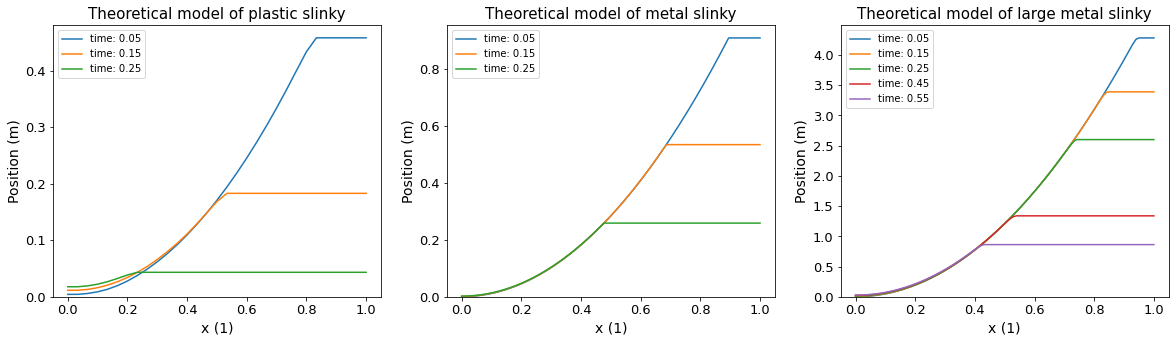

In [24]:
# Model for metal slinky
import pandas as pd
import numpy as np

df_real = pd.read_csv("data_raw_slinkies_experiment_new_measurements.csv", delimiter=';')

df3 = pd.read_csv("Data_metal_big_slinky.csv", delimiter=',')
df3['sort'] = 'metal_big'
df1 = pd.read_csv("Data_metal_small_slinky.csv", delimiter=',')
df1['sort'] = 'metal'
df2 = pd.read_csv("Data_plastic_slinky.csv", delimiter=',')
df2['time']=df2['time'].astype(float)
df2['sort'] = 'plastic'
df = pd.concat([df1, df2, df3])
sorts = ['plastic', 'metal', 'metal_big']
#plt.plot(df_max['time'], df_max['velocity'])
#plt.plot(df['position'], df['velocity'])
plt.show()
fig, axs = plt.subplots(1,3, figsize=(20,5))

times = [ 0.05,0.1, 0.2, 0.25]
trials = np.arange(0, 7)
i = 0

df_combined_real = pd.DataFrame()
for sort in sorts:
    combine_trials = pd.DataFrame()
    for trial in trials:
        df_real_filter = pd.DataFrame()
        df_real_filter = df_real[(df_real['Trial'] == trial) & (df_real['Sort'] == sort)].copy()
        if trial == 6 and sort == 'metal_big':
            break
        if not df_real_filter.empty:
            
            df_real_filter = df_real_filter.rename_axis('index1').reset_index()
            #df_real_filter.y = df_real_filter.y.values[::-1]
            
            df_real_filter['zeta'] = df_real_filter.index / (len(df_real_filter['y'])-1)
            
        #df_real_filter["zeta"] = pd.to_numeric(df_real_filter["zeta"])
            df_real_filter['zeta'] = df_real_filter['zeta'].astype(float).round(2)
            df_real_filter.set_index(['index1'])
            df_real_filter['Sort'] = sort
        #df_real_filter.zeta = df.zeta.values[::-1]
        combine_trials = pd.concat([combine_trials, df_real_filter])
        
    df_real_groupby = combine_trials.groupby(['zeta'])['y'].mean().abs().reset_index()
    df_real_groupby['Sort'] = sort
    df_real_groupby_std = combine_trials.groupby(['zeta'])['y'].std().reset_index()
        #print(df_real_groupby_std)
    df_real_groupby_std = df_real_groupby_std.rename(columns={'y': 'std_y'})
    df_real_groupby_std['Sort'] = sort
    
        #print(df_real_groupby_std)
   
    df_combined_real = pd.concat([df_combined_real, df_real_groupby, df_real_groupby_std])
    
    
    df_real_combined_filter = df_combined_real[(df_combined_real['Sort'] == sort)].copy()
    #df_real_combined_filter = df_real_combined_filter.transpose()
    #print(df_real_combined_filter)
    sortname = sort
    if sort =='metal_big':
        sortname = 'large metal'
    title_name_position = 'Theoretical model of '+sortname+' slinky'
    df_f = df[(df['sort'] == sort)]
    if sort == 'plastic':
        times = [ 0.053177,0.158528, 0.259866]
        #df_f['time'] = round(df_f['time'],3)
    if sort == 'metal':
        times = [ 0.05,0.15, 0.25]
    if sort == 'metal_big':
        times = [ 0.05,0.15, 0.25, 0.45, 0.55]
    for t in times:
        label_t = t
        if sort == 'plastic':
            label_t = mt.floor(label_t * 100) / 100
        filtered_df = df_f[np.isclose(df_f['time'], t)].copy()
        filtered_df.drop_duplicates(['position'])
        max_value_index = filtered_df['position'].idxmax()
        max_value = filtered_df['position'].max()
        filtered_df.loc[filtered_df.index > max_value_index, 'position'] = max_value
        axs[i].plot(filtered_df['zeta'], filtered_df['position'], label='time: '+str(label_t))
        axs[i].legend()
        axs[i].set_ylim(0)
        axs[i].set_title(title_name_position, fontsize=15)

    #axs[i].plot(df_real_combined_filter['zeta'], df_real_combined_filter['y'], label=sort)
    axs[i].legend()
    axs[i].set_ylim(0)
    axs[i].set_title(title_name_position, fontsize=15)
    axs[i].set_xlabel('x (1)', fontsize=14)
    axs[i].set_ylabel('Position (m)', fontsize=14)
    axs[i].tick_params(axis='both', labelsize=13)
    i += 1
plt.savefig("Times_model_graph.pdf")


